- https://huggingface.co/Helsinki-NLP/opus-mt-ko-en
- https://huggingface.co/docs/transformers/model_doc/marian
- https://github.com/huggingface/transformers/blob/v4.33.0/src/transformers/models/marian/modeling_marian.py#L1106

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade transformers
!pip install accelerate -U
!pip install sentencepiece
!pip install sacremoses
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=066addaa26f1798ae1855a330ac9023689499cb98585476024774cdc647d9c75
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import pipeline
from transformers import MarianTokenizer, MarianMTModel, MarianConfig, MarianModel
from transformers import AdamW, get_scheduler

import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import time

# 1.test 데이터셋 정의

In [ ]:
# 데이터 경로
path = "/content/drive/MyDrive/data/shuffled_kor_eng_concat_dataset.csv"

# 데이터 불러오기
df = pd.read_csv(path, encoding='utf-8')

df.head()

,원문,번역문
0,그들 체면이 말이 아닙니다.,They ought to be ashamed of their reputation.
1,한화의 공격력이 나아지지 않는다면 지난해와 같은 성적은 기대하기 어렵다.,"If Hanwha's offense doesn't improve, it's hard..."
2,"오프라인 프로그램에서는 창의적 사고기법과 문제해결방법, 의사소통 능력과 협업능력 등...","In the offline program, creativity and charact..."
3,"행사에는 유주현 대한건설협회 회장을 비롯해 최영묵 건설공제조합 이사장, 임영헌 대한...","More than 100 people attended the event, inclu..."
4,이들은 데이터 무제한 요금제가 있다는 것에 놀랐다.,They were surprised that there was an unlimite...


In [ ]:
# 데이터 분할
train_df = df[:1000]
valid_df = df[1000:1100]
test_df = df[1100:1200]

train_df.shape, valid_df.shape, test_df.shape

((1000, 2), (100, 2), (100, 2))

In [ ]:
input_train = train_df['원문']
target_train = train_df['번역문']

input_valid = valid_df['원문']
target_valid = valid_df['번역문']

input_test = test_df['원문']
target_test = test_df['번역문']

input_train.shape, target_train.shape

((1000,), (1000,))

# 4.Dataset, DataLoader

### 4-1. Dataset 정의

In [ ]:
# 데이터 로딩 및 전처리를 위한 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, source_df, target_df, tokenizer, max_length=128):
        self.source_sentences = source_df.reset_index().drop('index', axis=1).values.tolist()
        self.target_sentences = target_df.reset_index().drop('index', axis=1).values.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        source_text = self.source_sentences[idx][0]
        target_text = self.target_sentences[idx][0]

        # 토큰화 및 패딩
        source_tokens = self.tokenizer(source_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)
        target_tokens = self.tokenizer(target_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)

        # 아래 부분을 수정하여 input_ids를 반환하도록 재정의
        return {'input_ids': torch.tensor(source_tokens['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(source_tokens['attention_mask'], dtype=torch.long),
                'decoder_input_ids': torch.tensor(target_tokens['input_ids'], dtype=torch.long)}

In [ ]:
# train_df.head()

In [ ]:
# source_sentences = train_df['원문'].reset_index().drop('index', axis = 1).values.tolist()
# # print(source_sentences)

# source_text = source_sentences[0][0]
# print(source_text)

# source_tokens = tokenizer(source_text, add_special_tokens=True, max_length=128, padding="max_length", truncation=True)
# print(source_tokens)

# print(torch.tensor([source_tokens['input_ids'], source_tokens['attention_mask']], dtype=torch.long))

In [ ]:
# 토크나이저 및 vocab 로드
model_name = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 데이터셋 생성
train_dataset = CustomDataset(input_train, target_train, tokenizer)
valid_dataset = CustomDataset(input_valid, target_valid, tokenizer)
test_dataset = CustomDataset(input_test, target_test, tokenizer)

train_dataset, valid_dataset, test_dataset

(<__main__.CustomDataset at 0x7b33bfe8a7d0>,
 <__main__.CustomDataset at 0x7b33bfe8a560>)

In [ ]:
# len(train_dataset)

In [ ]:
# train_dataset[0]

### 4-2. DataLoader

In [ ]:
batch_size = 64

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_dl, valid_dl

(<torch.utils.data.dataloader.DataLoader at 0x7b33bfcf0cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b33bfcf0490>)

In [ ]:
# next(iter(dataloader))

In [ ]:
# next(iter(dataloader))['input_ids'].shape

In [ ]:
batch = next(iter(train_dl))
batch

{'input_ids': tensor([[  968,  6769,   225,  ..., 65000, 65000, 65000],
         [   54,   633,    53,  ..., 65000, 65000, 65000],
         [  515,   954, 12361,  ..., 65000, 65000, 65000],
         ...,
         [ 2928,   303,  1513,  ..., 65000, 65000, 65000],
         [   25,  6166, 20676,  ..., 65000, 65000, 65000],
         [ 1241,  2265,  5151,  ..., 65000, 65000, 65000]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'decoder_input_ids': tensor([[  180,     9, 20747,  ..., 65000, 65000, 65000],
         [   16,  1931,  1753,  ..., 65000, 65000, 65000],
         [  138,     4,     9,  ..., 65000, 65000, 65000],
         ...,
         [ 1431,  8513,   649,  ..., 65000, 65000, 65000],
         [   57,   575,  3154,  ..., 65000, 65000, 65000],
         [   16,    12,   250,  ..., 65000,

In [ ]:
len(train_dl)

15

In [ ]:
input_ids = batch['input_ids']
input_ids, input_ids.shape

(tensor([[  968,  6769,   225,  ..., 65000, 65000, 65000],
         [   54,   633,    53,  ..., 65000, 65000, 65000],
         [  515,   954, 12361,  ..., 65000, 65000, 65000],
         ...,
         [    9, 27161,  8267,  ..., 65000, 65000, 65000],
         [13261,   734, 10544,  ..., 65000, 65000, 65000],
         [33163,   308,  2927,  ..., 65000, 65000, 65000]]),
 torch.Size([16, 128]))

In [ ]:
translated_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
print(translated_ids), len(translated_ids)

tensor([[65000,   180,   190,    12,    49,   369,   135,   631,     2,     0,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000],
        [65000,    91,    12,    10,   857,     5,  2889, 23924,   135,   556,
           389,  4916,     4,  4123,     5, 13477, 24003,    20,  1037,   551,
             2,     0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000],
        [65000,    57, 22975,  5805,  2430,    61,  1851, 10648,  1175, 16779,
             3,   783, 21687,     3,  5671,     8, 41883,     3,    50,   290,
            50, 10

(None, 16)

In [ ]:
for i in range(len(translated_ids)):
    translated_text = tokenizer.decode(translated_ids[i], skip_special_tokens=True)
    print(f"{i+1}번째 번역 결과:", translated_text)

1번째 번역 결과: In my freshman year in college, I basically learn a lot of subjects.
2번째 번역 결과: Police and fire departments estimate Mr. Kim's foot has been knocked off the rock wall, and they are investigating exactly how the accident took place.


In [ ]:
batch['decoder_input_ids']

tensor([[ 1278,  1641,  1252,    18,    38,    11,  1731,   101,  9810,  1662,
             3,    18,   575,  2025,  1212,  5838,  4874, 12470,   649,     9,
          8186,  2895,  3674,   979,  6663, 46805,    10,     2,     0, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 6

In [ ]:
for i in range(len(batch['decoder_input_ids'])):
    translated_text = tokenizer.decode(batch['decoder_input_ids'][i], skip_special_tokens=True)
    print(f"{i+1}번째 정답 결과:", translated_text)

1번째 정답 결과: When you are a freshman, you basically learn various subjects.
2번째 정답 결과: Police and fire authorities suspect that Kim lost his footing on the rock wall and caused the accident, and are investigating the exact circumstances.


In [ ]:
# model(input_ids=batch['input_ids'], decoder_input_ids=batch['decoder_input_ids'])

In [ ]:
# config = MarianConfig.from_pretrained(model_name)
# config.decoder_layers = 1

# new_model = MarianMTModel.from_pretrained(model_name, config=config).to(device)
# new_model

In [ ]:

# input_ids = batch['input_ids'].to(device)
# decoder_input_ids = batch['decoder_input_ids'].to(device)

# output = new_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
# output

# 5.새로운 모델 정의

In [ ]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# class TranslationModel(nn.Module):
#     def __init__(self, pretrained_model_name = 'Helsinki-NLP/opus-mt-ko-en', num_decode_layers = 1):
#         super(TranslationModel, self).__init__()
#         # encoder-decoder 모델 가져오기
#         self.marian_model = MarianMTModel.from_pretrained(pretrained_model_name)

#         # 추가할 레이어
#         self.dropout = nn.Dropout(dropout_prob)
#         self.layer_norm = nn.LayerNorm(self.marian_model.config.hidden_size)
#         self.lm_head = self.marian_model.lm_head

#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     def forward(self, input_ids, decoder_input_ids):

#         # encoder / decoder 입력값
#         input_ids = input_ids.to(self.device)                   # encoder input
#         decoder_input_ids = decoder_input_ids.to(self.device)   # decoder input

#         # 기존 모델
#         logits = self.marian_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids).logits
#         # logits = outputs.logits

#         # 추가한 레이어
#         layer_norm_shape = list(logits.size()[1:])
#         layer_norm = nn.LayerNorm(layer_norm_shape).to(self.device)

#         # Apply dropout and layer normalization
#         logits = self.dropout(logits)
#         logits = layer_norm(logits)

#         return logits

In [ ]:
# class TranslationModel(nn.Module):
#     def __init__(self, model_name = 'Helsinki-NLP/opus-mt-ko-en', num_decode_layers = 1):
#         super(TranslationModel, self).__init__()
#         self.config = MarianConfig.from_pretrained(model_name)
#         self.config.decoder_layers = num_decode_layers
#         self.marian = MarianMTModel.from_pretrained(model_name, config=self.config)

#         for param in self.marian.get_encoder().parameters():
#                 param.requires_grad = False

#     def forward(self, input_ids, decoder_input_ids):
#         result = self.marian(input_ids, decoder_input_ids)

#         return result[0]


#     def generate(self, input_ids):
#         result = self.marian(input_ids)

#         return result[0]

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 새로운 모델 생성
# new_model = TranslationModel().to(device)
# new_model

In [ ]:
# 디코더 레이어 6 -> 1
model_name = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)

config = MarianConfig.from_pretrained(model_name)
config.decoder_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

new_model = MarianMTModel.from_pretrained(model_name, config=config).to(device)
new_model

Some weights of the model checkpoint at Helsinki-NLP/opus-mt-ko-en were not used when initializing MarianMTModel: ['model.decoder.layers.3.final_layer_norm.bias', 'model.decoder.layers.5.self_attn_layer_norm.weight', 'model.decoder.layers.3.encoder_attn.out_proj.bias', 'model.decoder.layers.3.self_attn.k_proj.bias', 'model.decoder.layers.5.self_attn.k_proj.bias', 'model.decoder.layers.1.encoder_attn.out_proj.weight', 'model.decoder.layers.3.self_attn.v_proj.weight', 'model.decoder.layers.3.encoder_attn.v_proj.bias', 'model.decoder.layers.1.fc2.weight', 'model.decoder.layers.3.encoder_attn.out_proj.weight', 'model.decoder.layers.4.self_attn_layer_norm.weight', 'model.decoder.layers.1.self_attn.q_proj.weight', 'model.decoder.layers.3.fc1.weight', 'model.decoder.layers.4.self_attn.out_proj.weight', 'model.decoder.layers.2.fc1.weight', 'model.decoder.layers.3.self_attn_layer_norm.weight', 'model.decoder.layers.2.encoder_attn_layer_norm.weight', 'model.decoder.layers.5.encoder_attn.k_proj.w

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# 데이터 로더 test
batch_size = 2
dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader

In [ ]:
batch = next(iter(dataloader))
batch

{'input_ids': tensor([[ 6542,   132, 18454,  2679, 11538,  2482, 33142,   546,  1426, 16710,
              2,     0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 650

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_ids = batch['input_ids'].to(device)
input_ids, input_ids.shape

(tensor([[ 6542,   132, 18454,  2679, 11538,  2482, 33142,   546,  1426, 16710,
              2,     0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
          65000, 65000, 65000, 65000, 65

In [ ]:
translated_ids = new_model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
print(translated_ids), len(translated_ids)

tensor([[65000,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,     9,     9,     9,     9,
             9,     9,     9,     9,     9,     9,  

(None, 2)

In [ ]:
for i in range(len(translated_ids)):
    translated_text = tokenizer.decode(translated_ids[i], skip_special_tokens=True)
    print(f"{i+1}번째 번역 결과:", translated_text)

1번째 번역 결과: 
2번째 번역 결과: 


In [ ]:
batch['decoder_input_ids']

tensor([[ 1278,  1641,  1252,    18,    38,    11,  1731,   101,  9810,  1662,
             3,    18,   575,  2025,  1212,  5838,  4874, 12470,   649,     9,
          8186,  2895,  3674,   979,  6663, 46805,    10,     2,     0, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 6

In [ ]:
for i in range(len(batch['decoder_input_ids'])):
    translated_text = tokenizer.decode(batch['decoder_input_ids'][i], skip_special_tokens=True)
    print(f"{i+1}번째 정답 결과:", translated_text)

1번째 정답 결과: When you are a freshman, you basically learn various subjects.
2번째 정답 결과: Police and fire authorities suspect that Kim lost his footing on the rock wall and caused the accident, and are investigating the exact circumstances.


# 6.모델 학습 및 검증

### 6-1.기존 모델 학습

In [ ]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# 손실 함수, 옵티마이저, 디바이스 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# encoder 파라미터 동결시키기
for param in model.model.encoder.parameters():
    param.requires_grad = False

# loss 저장 리스트
train_loss_list = []
valid_loss_list = []

num_epochs = 300

total_start = time.time()
for epoch in range(num_epochs):

    epoch_start = time.time()
    model.train()
    train_epoch_loss = 0.0

    for train_batch in train_dl:

        input_ids = train_batch['input_ids'].to(device)                  # 인코더 input
        attention_mask = train_batch['attention_mask'].to(device)
        decoder_input_ids = train_batch['decoder_input_ids'].to(device)  # 디코더 input

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        decoder_input_ids=decoder_input_ids)

        # loss 계산
        train_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
        train_epoch_loss += train_batch_loss.item()

    train_epoch_loss = train_epoch_loss/len(train_dl)
    train_loss_list.append(train_epoch_loss)

    train_batch_loss.backward()
    optimizer.step()

    print('Epoch:', '%02d' % (epoch + 1))
    print('train loss =', '{:.6f}'.format(train_epoch_loss))

    #####################################################################################################################

    model.eval()
    with torch.no_grad():

        valid_epoch_loss = 0.0

        for valid_batch in valid_dl:

            input_ids = valid_batch['input_ids'].to(device)                  # 인코더 input
            attention_mask = valid_batch['attention_mask'].to(device)
            decoder_input_ids = valid_batch['decoder_input_ids'].to(device)  # 디코더 input

            # 모델에 입력을 전달하여 예측값 얻기
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            decoder_input_ids=decoder_input_ids)

            # 손실 계산
            valid_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
            valid_epoch_loss += valid_batch_loss.item()

        valid_epoch_loss = valid_epoch_loss/len(valid_dl)
        valid_loss_list.append(valid_epoch_loss)

        print('validation loss =', '{:.6f}'.format(valid_epoch_loss))

    epoch_end = time.time()
    print(f'time per epoch: {round(epoch_end-epoch_start, 4)}초')
    print('==============================')

total_end = time.time()
print(f'총 걸린시간: {round(total_end-total_start, 4)}')

torch.save(model, '/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model_v2.pth')

Epoch: 01
train loss = 5.741804
validation loss = 4.429051
time per epoch: 5.6668초
Epoch: 02
train loss = 4.408814
validation loss = 3.958311
time per epoch: 1.9993초
Epoch: 03
train loss = 3.922578
validation loss = 3.695023
time per epoch: 1.9951초
Epoch: 04
train loss = 3.682182
validation loss = 3.505053
time per epoch: 1.9999초
Epoch: 05
train loss = 3.537285
validation loss = 3.378473
time per epoch: 1.9956초
Epoch: 06
train loss = 3.431381
validation loss = 3.256792
time per epoch: 2.0238초
Epoch: 07
train loss = 3.306300
validation loss = 3.152101
time per epoch: 1.9931초
Epoch: 08
train loss = 3.184725
validation loss = 3.072425
time per epoch: 1.9955초
Epoch: 09
train loss = 3.094312
validation loss = 3.011566
time per epoch: 1.9913초
Epoch: 10
train loss = 3.018655
validation loss = 2.957189
time per epoch: 1.9953초
Epoch: 11
train loss = 2.955055
validation loss = 2.910146
time per epoch: 1.9935초
Epoch: 12
train loss = 2.902027
validation loss = 2.869959
time per epoch: 2.0201초
Epoc

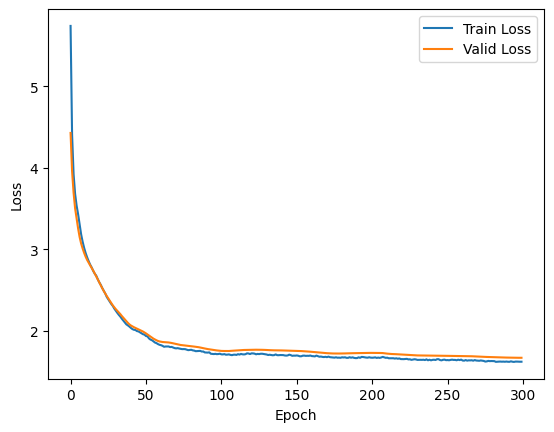

In [ ]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 모델 정확도 측정
trained_model = torch.load('/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model_v2.pth')
trained_model.eval()

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
batch = next(iter(train_dl))
batch

{'input_ids': tensor([[  968,  6769,   225,  ..., 65000, 65000, 65000],
         [   54,   633,    53,  ..., 65000, 65000, 65000],
         [  515,   954, 12361,  ..., 65000, 65000, 65000],
         ...,
         [ 2928,   303,  1513,  ..., 65000, 65000, 65000],
         [   25,  6166, 20676,  ..., 65000, 65000, 65000],
         [ 1241,  2265,  5151,  ..., 65000, 65000, 65000]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'decoder_input_ids': tensor([[  180,     9, 20747,  ..., 65000, 65000, 65000],
         [   16,  1931,  1753,  ..., 65000, 65000, 65000],
         [  138,     4,     9,  ..., 65000, 65000, 65000],
         ...,
         [ 1431,  8513,   649,  ..., 65000, 65000, 65000],
         [   57,   575,  3154,  ..., 65000, 65000, 65000],
         [   16,    12,   250,  ..., 65000,

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_ids = batch['input_ids'].to(device)
input_ids, input_ids.shape

(tensor([[  968,  6769,   225,  ..., 65000, 65000, 65000],
         [   54,   633,    53,  ..., 65000, 65000, 65000],
         [  515,   954, 12361,  ..., 65000, 65000, 65000],
         ...,
         [ 2928,   303,  1513,  ..., 65000, 65000, 65000],
         [   25,  6166, 20676,  ..., 65000, 65000, 65000],
         [ 1241,  2265,  5151,  ..., 65000, 65000, 65000]], device='cuda:0'),
 torch.Size([64, 128]))

In [ ]:
translated_ids = trained_model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
print(translated_ids), len(translated_ids)

tensor([[65000,    91,    12,  ..., 65000, 65000, 65000],
        [65000,    91,    12,  ..., 65000, 65000, 65000],
        [65000,    57,   403,  ..., 65000, 65000, 65000],
        ...,
        [65000,   138,    11,  ...,     4,     4,     0],
        [65000,    57, 35837,  ..., 65000, 65000, 65000],
        [65000,    16,    12,  ..., 65000, 65000, 65000]], device='cuda:0')


(None, 64)

In [ ]:
for i in range(len(translated_ids)):
    translated_text = tokenizer.decode(translated_ids[i], skip_special_tokens=True)
    print(f"{i+1}번째 번역 결과:", translated_text)

1번째 번역 결과: It's not that they're in on their face.
2번째 번역 결과: It's hard to expect the same results as the last year, if the damages of the Korean language are not getting better.
3번째 번역 결과: The off-line program will provide creative thinking and problem solving, communication and collaboration, as well as the creative and human-related education that the 21st century future society needs.
4번째 번역 결과: At the event, more than a hundred of them were present, including the president of the United States, the President of the the Society for the Construction of the Sea of the Sea, the head of the Society's Society for Constructional Contribution, and the head of this two-way construction industry.
5번째 번역 결과: They were surprised to have a data-limited charge.
6번째 번역 결과: I can't find it. Which wall is it on?
7번째 번역 결과: In the case of the golden race, on the fourth day, only 13 substraterations will be launched, and on the 11/18/25th day, there will be 11 substratesssssssssseseses, four station

In [ ]:
batch['decoder_input_ids']

tensor([[  180,     9, 20747,  ..., 65000, 65000, 65000],
        [   16,  1931,  1753,  ..., 65000, 65000, 65000],
        [  138,     4,     9,  ..., 65000, 65000, 65000],
        ...,
        [ 1431,  8513,   649,  ..., 65000, 65000, 65000],
        [   57,   575,  3154,  ..., 65000, 65000, 65000],
        [   16,    12,   250,  ..., 65000, 65000, 65000]])

In [ ]:
for i in range(len(batch['decoder_input_ids'])):
    translated_text = tokenizer.decode(batch['decoder_input_ids'][i], skip_special_tokens=True)
    print(f"{i+1}번째 정답 결과:", translated_text)

1번째 정답 결과: They ought to be ashamed of their reputation.
2번째 정답 결과: If Hanwha's offense doesn't improve, it's hard to expect the same performance as last year.
3번째 정답 결과: In the offline program, creativity and character-related education required for the future society of the 21st century will be provided, including creative thinking techniques, problem solving methods, communication skills and ability to collaborate.
4번째 정답 결과: More than 100 people attended the event, including the chairman of the Construction Association of Korea Yoo Joo-hyun, Chairman of the Construction Guarantee Cooperative Choi Young-muk, Chairman of the Construction Association of Korea's Committee for Promotion of Social Contribution Projects Lim
5번째 정답 결과: They were surprised that there was an unlimited data plan.
6번째 정답 결과: I can't find it, which wall is it posted on?
7번째 정답 결과: In the case of the horse race of Friday, only 13 races for Bugyeong will be released on the 4th, while 11 races for Bugyeong City an

### 6-2.새로운 모델 학습

In [ ]:
new_model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# 손실 함수, 옵티마이저, 디바이스 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

# encoder 파라미터 동결시키기
for param in new_model.model.encoder.parameters():
    param.requires_grad = False

# loss 저장 리스트
train_loss_list = []
valid_loss_list = []

num_epochs = 1

total_start = time.time()
for epoch in range(num_epochs):

    epoch_start = time.time()
    new_model.train()
    train_epoch_loss = 0.0

    for train_batch in train_dl:

        input_ids = train_batch['input_ids'].to(device)
        attention_mask = train_batch['attention_mask'].to(device)
        decoder_input_ids = train_batch['decoder_input_ids'].to(device)

        optimizer.zero_grad()

        outputs = new_model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            decoder_input_ids=decoder_input_ids)
        # print(outputs)

        # loss 계산
        train_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
        train_epoch_loss += train_batch_loss.item()

        # # 'Seq2SeqLMOutput' 객체에서 'logits' 추출
        # pred_logits = pred.logits

        # pred = pred_logits.transpose(0, 1)
        # output = output.transpose(0, 1)

        # # loss 계산
        # train_batch_loss = 0.0
        # for i in range(128):  # input_size만큼 돌기
        #     train_batch_loss += criterion(pred[i], output[i])
        # train_batch_loss = train_batch_loss/128

        # train_epoch_loss += train_batch_loss

    train_epoch_loss = train_epoch_loss/len(train_dl)
    train_loss_list.append(train_epoch_loss)

    train_batch_loss.backward()
    optimizer.step()

    print('Epoch:', '%02d' % (epoch + 1))
    print('train loss =', '{:.6f}'.format(train_epoch_loss))

######################################################################################################################################################

    new_model.eval()
    with torch.no_grad():
        valid_epoch_loss = 0.0
        for valid_batch in valid_dl:
            input_ids = valid_batch['input_ids'].to(device)
            attention_mask = valid_batch['attention_mask'].to(device)
            decoder_input_ids = valid_batch['decoder_input_ids'].to(device)

            # 모델에 입력을 전달하여 예측값 얻기
            outputs = new_model(input_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_input_ids=decoder_input_ids)

            # 손실 계산
            valid_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
            valid_epoch_loss += valid_batch_loss.item()

            # # 'Seq2SeqLMOutput' 객체에서 'logits' 추출
            # pred_val_logits = pred_val.logits

            # pred_val = pred_val_logits.transpose(0, 1)
            # output_val = output_val.transpose(0, 1)

            # valid_batch_loss = 0.0
            # for i in range(128):
            #     valid_batch_loss += criterion(pred_val[i], output_val[i])
            # valid_batch_loss = valid_batch_loss/128

            # valid_epoch_loss += valid_batch_loss

        valid_epoch_loss = valid_epoch_loss/len(valid_dl)
        valid_loss_list.append(valid_epoch_loss)

        print('validation loss =', '{:.6f}'.format(valid_epoch_loss))

    epoch_end = time.time()
    print(f'time per epoch: {round(epoch_end-epoch_start, 4)}초')
    print('==============================')

total_end = time.time()
print(f'총 걸린시간: {round(total_end-total_start, 4)}')
torch.save(new_model, '/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model_v1.pth')

Epoch: 01
 train loss = 4.957837
validation loss = 3.972659
총 걸린시간: 0.8349


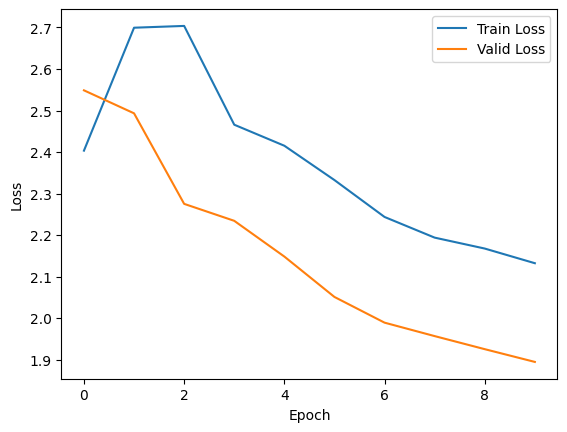

In [ ]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 6-3.모델 검증

In [ ]:
new_model = torch.load('/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model_v1.pth')
new_model.eval()

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

test_loss = 0
correct = 0

with torch.no_grad():
    for train_batch in train_dl:

        input_ids = train_batch['input_ids'].to(device)
        decoder_input_ids = train_batch['decoder_input_ids'].to(device)

        output = new_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids).logits

        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        decoder_input_ids = decoder_input_ids.view(-1)

        test_loss += criterion(output, decoder_input_ids).item()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(decoder_input_ids.view_as(pred)).sum().item()

# loss 계산
test_loss /= len(train_dl.dataset)

# 테스트 데이터셋 크기 계산
test_dataset_size = len(train_dl.dataset)

print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, test_dataset_size, 100. * correct / test_dataset_size))


Test set: Average Loss: 0.3863, Accuracy: 8721/900 (969.00%)



In [ ]:
# 자동완성 기능을 보니까 logits이 있고 pred_logits이 있던데 차이점은

In [ ]:
batch = next(iter(train_dl))
batch

{'input_ids': tensor([[  968,  6769,   225,  ..., 65000, 65000, 65000],
         [   54,   633,    53,  ..., 65000, 65000, 65000],
         [  515,   954, 12361,  ..., 65000, 65000, 65000],
         ...,
         [    9, 27161,  8267,  ..., 65000, 65000, 65000],
         [13261,   734, 10544,  ..., 65000, 65000, 65000],
         [33163,   308,  2927,  ..., 65000, 65000, 65000]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'decoder_input_ids': tensor([[  180,     9, 20747,  ..., 65000, 65000, 65000],
         [   16,  1931,  1753,  ..., 65000, 65000, 65000],
         [  138,     4,     9,  ..., 65000, 65000, 65000],
         ...,
         [ 1048,  2906,   130,  ...,     0, 65000, 65000],
         [  116, 38562,  2582,  ..., 65000, 65000, 65000],
         [  138,   696,   897,  ..., 65000,

### 6-4.새로운 모델 BeLU 측정 - 100개

In [ ]:
input_test = test_df['원문']
target_test = test_df['번역문']

In [ ]:
# 원본과 번역본
original_text_list = input_test[:100].tolist()      # 한글
translated_text_list = target_test[:100].tolist()   # 영어

original_text_list[:5], translated_text_list[:5]

(['국민연금이 하반기 ‘스튜어드십 코드’ 도입을 앞둔 가운데, 국민연금이 5% 이상 지분을 보유한 기업 중 배당을 하지 않거나 배당성향이 낮은 기업이 스튜어드십 코드 수혜주로 떠올랐다.',
  '흥국생명은 3일 전 5라운드 첫 경기를 치러 이틀만 쉬고 경기를 치렀으나 체력적으로 큰 문제가 없어 보였다.',
  '오즈의 마법사를 만나러 가는 길에 강을 건너는 장면이 있었어요.',
  '서울공연에서는 시각장애인 정선화 명창이 심청가 중 시각장애인 눈뜨는 대목을 인천시 무형무형재 23호인 고법(북·장구) 예능보유자 시각장애인 조경곤 명고의 북소리에 맞춰 판소리 한 대목을 부를 예정이다.',
  '구청장은 천재지변 등 불가항력의 사유로 광고게재가 불가능할 경우 광고게재를 아니할 수 있고, 이 경우 이미 납입한 광고료 중 잔여기간에 해당하는 금액을 광고주에게 반환하여야 한다.'],
 ['With the National Pension Service set to introduce the "Stewardship Code" in the second half, companies with no or low propensity to dividend among the companies in which 5% or more of the stake is owned by National Pension Service has emerged as the beneficiaries of the Stewardship Code.',
  "Heungkuk Life played the first game of the fifth round three days ago and rested for two days, but it didn't seem to have any physical problems.",
  'There was a scene where she crosses the river on the way to meet the wizard of OZ.',
  'In the Seoul concert, the

In [ ]:
new_model = torch.load('/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model_v1.pth')

In [ ]:
# 한글 텍스트를 토큰화하고 번역된 결과를 리스트에 저장하는 테스트
device = "cuda" if torch.cuda.is_available() else "cpu"

new_modeling_text_list = []

for korean in original_text_list:

    input_ids = tokenizer.encode(korean, return_tensors="pt", max_length=1024, truncation=True)
    input_ids = input_ids.to(device)

    translated_ids = new_model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True).to(device)
    translated_ids = translated_ids.to(device)

    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)

    new_modeling_text_list.append(translated_text)

new_modeling_text_list[:5]

['', '', '', '', '']

In [ ]:
# 문장을 토큰 리스트로 변환하는 함수
def num_to_char(input_ids):
    text = []
    vocab = tokenizer.get_vocab()
    for number in input_ids:
        if number in [0, 65000]:
            continue  # number가 0, 65000이면 다음 반복으로 넘어감
        char = next(key for key, value in vocab.items() if value == number)
        text.append(char)
    return text


# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"
# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

num_sentences = 100  # 100개로 test함으로 범위를 100으로 지정
total_belu_score = []

for i in range(num_sentences):

    # Reference 문장과 Candidate 문장 토큰화
    reference_tokens = num_to_char(tokenizer(translated_text_list[i])['input_ids'])
    candidate_tokens = num_to_char(tokenizer(new_modeling_text_list[i])['input_ids'])

    # BLEU Score 계산
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))  # (원본 번역문, 모델 번역문)
    total_belu_score.append(bleu_score)

    if i < 20:
        # BLEU 점수 출력
        print(f"{i}번째 | 원본 번역본: {translated_text_list[i]}")
        print(f"{i}번째 | 모델 번역본: {new_modeling_text_list[i]}")
        print(f"{i}번째 | 원본 번역본 토큰: {reference_tokens}")
        print(f"{i}번째 | 모델 번역본 토큰: {candidate_tokens}")
        print(f"{i}번째 | BLEU 점수: {bleu_score}")
        print("----------------------------------------------------------------------------------------------------")
    else:
        pass

# 전체 blue 평균 계산
average_bleu_score = sum(total_belu_score) / num_sentences
print(f"100문장에 대한 Belu Score 평균: {average_bleu_score}")

0번째 | 원본 번역본: A team led by Kang Sang-beom, a professor of gastroenterology division at the Catholic University of Korea's Daejeon St. Mary's Hospital, announced on the 25th that it has succeeded in "feces microbiome transplant" to treat gastrointestinal colitis of severe symptoms using feces from healthy people.
0번째 | 모델 번역본: 
0번째 | 원본 번역본 토큰: ['▁A', '▁', 'te', 'am', '▁l', 'ed', '▁by', '▁K', 'ang', '▁S', 'ang', '-', 'be', 'om', ',', '▁a', '▁pro', 'f', 'ess', 'or', '▁of', '▁g', 'ast', 'ro', 'ent', 'er', 'ology', '▁d', 'iv', 'is', 'ion', '▁', 'at', '▁the', '▁C', 'ath', 'ol', 'ic', '▁Un', 'iv', 'ers', 'ity', '▁of', '▁K', 'ore', 'a', "'", 's', '▁D', 'a', 'e', 'j', 'e', 'on', '▁St', '.', '▁Mar', 'y', "'", 's', '▁Ho', 'sp', 'it', 'al', ',', '▁', 'an', 'no', 'un', 'c', 'ed', '▁on', '▁the', '▁25', 'th', '▁that', '▁it', '▁h', 'as', '▁', 'su', 'c', 'ce', 'ed', 'ed', '▁in', '▁"', 'fe', 'ce', 's', '▁m', 'ic', 'ro', 'bi', 'ome', '▁t', 'ran', 's', 'pl', 'ant', '"', '▁to', '▁t', 're', 'at', '▁g', 'a